#### Importando as bibliotecas necessárias


In [1]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.8 MB/s 


In [2]:
pip install scikit-learn==0.24.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [3]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import PorterStemmer
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('rslp')
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


#### Acessando o google drive e abrindo o dataset da b2w


In [4]:
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
df_reviews = pd.read_csv(r'/gdrive/My Drive/Análise de Sentimentos/B2W-Reviews01.csv',sep=';')

#### Tirando as avaliações neutras do dataset (3 estrelas).

In [6]:
df_reviews = df_reviews.drop(df_reviews[df_reviews.overall_rating == 3].index)

#### Checando a distribuição do dataset: Será nencessário balancear. 

#### As avaliações com 1 e 2 estrelas serão definidas como negativas (0) e as avaliações dom 4 e 5 estrealas serão definidas como positivas (1).

In [7]:
df_reviews.overall_rating.value_counts()

5.0    47971
4.0    32345
1.0    27371
2.0     8389
Name: overall_rating, dtype: int64

In [8]:
df_reviews['overall_rating'].replace([1,2], 0, inplace=True)
df_reviews['overall_rating'].replace([4,5], 1,inplace=True)

In [9]:
df_reviews.overall_rating.value_counts()

1.0    80316
0.0    35760
Name: overall_rating, dtype: int64

In [10]:
#df_reviews = df_reviews[df_reviews['review_text'].str.len()<1000]

In [11]:
df_reviews_positive = df_reviews[df_reviews['overall_rating'] == 1].sample(frac=0.44)
#df_reviews_positive = df_reviews[df_reviews['overall_rating'] == 1].sample(n=df_reviews[df_reviews['overall_rating'] == 0].count()[0]#)
#df_reviews_negative = df_reviews[df_reviews['overall_rating'] == 0].sample(n=df_reviews[df_reviews['overall_rating'] == 0].count()[0])

In [12]:
df_reviews_negative = df_reviews[df_reviews['overall_rating'] == 0]

In [13]:
df_reviews = pd.concat([df_reviews_positive,df_reviews_negative], ignore_index=True)

#### A coluna *review_text* é renomeada para *text* e a coluna *overall_ratings* para *labels*.

In [14]:
df_reviews.rename(columns={'review_text':'text','overall_rating':'labels'},inplace=True)
df_reviews

,labels,text
0,1.0,Excelente. Recomendo a compra. Imagem sensacio...
1,1.0,Produto Excelente. Comprem sem medo. Entrega g...
2,1.0,"Nossa, eu adorei o produto, muito bom câmera m..."
3,1.0,Kit excelente! Potente. Dobravel. Nao ocupa es...
4,1.0,"Entrega rápida. Celular bonito, cheio de apl..."
...,...,...
71094,0.0,"O produto não tem uma trava para a tampa, quan..."
71095,0.0,"O travesseiro quando colocamos a cabeça, ele f..."
71096,0.0,Infelizmente o Netflix não funciona e esse era...
71097,0.0,"Material fraco, poderia ser melhor. Ficou deve..."


#### Agora, checa-se a distribuição do dataset, sendo importante que esteja balanceado.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


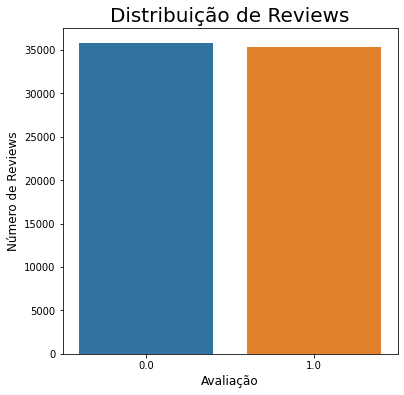

In [15]:
label_count = df_reviews['labels'].value_counts()
label_count = label_count.sort_index()

fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("Distribuição de Reviews",fontsize = 20)
plt.ylabel('Número de Reviews', fontsize = 12)
plt.xlabel('Avaliação', fontsize = 12);

#### Agora, são removidos os caracteres especiais, acentos, stopwords.
#### As sentenças também são convertidas para letra minúscula.
#### A função pre_processor faz todo esse trabalho, e será passada na vetorização do texto.

In [16]:
#@title Lista de Stopwords, o código está oculto por causa do tamanho.
stop_words = {'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houveríamos',
 'houvesse',
 'houvessem',
 'houvéramos',
 'houvéssemos',
 'há',
 'hão',
 'isso',
 'isto',
 'já',
 'lhe',
 'lhes',
 'mais',
 'mas',
 'me',
 'mesmo',
 'meu',
 'meus',
 'minha',
 'minhas',
 'muito',
 'na',
 'nas',
 'nem',
 'no',
 'nos',
 'nossa',
 'nossas',
 'nosso',
 'nossos',
 'num',
 'numa',
 'nós',
 'o',
 'os',
 'ou',
 'para',
 'pela',
 'pelas',
 'pelo',
 'pelos',
 'por',
 'qual',
 'quando',
 'que',
 'quem',
 'se',
 'seja',
 'sejam',
 'sejamos',
 'sem',
 'serei',
 'seremos',
 'seria',
 'seriam',
 'será',
 'serão',
 'seríamos',
 'seu',
 'seus',
 'somos',
 'sou',
 'sua',
 'suas',
 'são',
 'só',
 'também',
 'te',
 'tem',
 'temos',
 'tenha',
 'tenham',
 'tenhamos',
 'tenho',
 'terei',
 'teremos',
 'teria',
 'teriam',
 'terá',
 'terão',
 'teríamos',
 'teu',
 'teus',
 'teve',
 'tinha',
 'tinham',
 'tive',
 'tivemos',
 'tiver',
 'tivera',
 'tiveram',
 'tiverem',
 'tivermos',
 'tivesse',
 'tivessem',
 'tivéramos',
 'tivéssemos',
 'tu',
 'tua',
 'tuas',
 'tém',
 'tínhamos',
 'um',
 'uma',
 'você',
 'vocês',
 'vos',
 'à',
 'às',
 'é',
 'éramos',
 'acha'
 'pensa'
 'acho',
 'penso',
 'achei',
 'imagino',
 'pensei',
 'imaginei',
 'achava',
 'pensava'
 }

In [17]:
def pre_processor(text):
  text = text.lower()
  stemmer = nltk.stem.RSLPStemmer()
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokenized = word_tokenize(text)
  filtered_sentence = [word for word in tokenized if word not in stop_words ]
  return ' '.join(c for c in filtered_sentence if c.isalpha())


  #def tokenize_data(dataset):
   # tokenizer = nltk.tokenize.TreebankWordTokenizer()
    #for i in range(dataset.shape[0]):
     #  dataset["reviews"][i] = tokenizer.tokenize(dataset["reviews"][i])
    #return dataset

    #def normalize(dataset):
    #lemmatizer = nltk.stem.WordNetLemmatizer()
    #for i in range(dataset.shape[0]):
    #    dataset.reviews[i] = " ".join([lemmatizer.lemmatize(token) for token in dataset.reviews[i]]).strip()
    #return dataset

#### Agora é feita a divisão do dataset em treino (70%) e teste(30%).

In [18]:
train, test = train_test_split(df_reviews, test_size = 0.2, stratify = df_reviews['labels'], random_state = 42)

In [19]:
dataset_de_ajuste = pd.read_csv(r'/gdrive/My Drive/Análise de Sentimentos/dataset_ajuste_v4_binario.csv',sep=';', encoding='latin-1')
#train  = pd.concat([train,dataset_de_ajuste], ignore_index=True)

In [20]:
dataset_de_ajuste

,ï»¿labels,text
0,1,Excelente empresa!! Redonda!!
1,1,GestÃ£o excepcional de todo o Grupo. Esta apen...
2,1,"Acredito nela, Ã³timosÂ indicadores e excelent..."
3,1,"Ã³tima empresa, os gestores tem visÃ£o, sempre..."
4,1,"Excelente empresa, excelente case, Ã³timo para..."
...,...,...
672,0,LIXO DO CRL
673,0,ela esta fazendo isso para aparecer Nao e gay ...
674,0,Volta pra jaula sua macaca vou pegar meu xicot...
675,0,Achei que a macaca vivia apenas na floresta ou...


In [21]:
train['text']= train['text'].apply(pre_processor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Para que o algorítimo consiga processar o texto, é necessário convertê-lo em vetores.

#### Também são considerados binagramas (sequeência de duas palavras).

In [22]:
start_time = time.time()
#cv = CountVectorizer(binary=True, ngram_range=(1,2), min_df = 10, preprocessor= pre_processor)
cv = TfidfVectorizer(max_features=10000, preprocessor= pre_processor, ngram_range = (1,2))
cv.fit(train['text'].values)
train_feature_set=cv.transform(train['text'].values)
test_feature_set=cv.transform(test['text'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  2.64  mins


In [23]:
test

,labels,text
19748,1.0,Comprei o produto não esperando muito dele e s...
8846,1.0,"Cumpre o prometido, na primeira sessão e já te..."
21221,1.0,"O liquidificador é lindo , muito bom , não é b..."
16195,1.0,"Produto excelente, entrega antes da data previ..."
6988,1.0,"É um ótimo monitor, uma boa relação custo/bene..."
...,...,...
67571,0.0,eles gostam mesmo e de encher os bolsos deles...
2169,1.0,"Produto de acordo com o oferecido, em cor e qu..."
17511,1.0,"Bonitas, resistentes. Recomendo com certeza. E..."
17480,1.0,Produto completo de ótima qualidade. Superou m...


#### Checando quantas palavras unicas existem no dataset de treino

In [24]:
train_feature_set.shape[1]

10000

#### Armazenando as labels de treino e teste.



In [25]:
y_train = train['labels'].values
y_test = test['labels'].values

#### Validação cruzada do modelo

In [26]:
#from sklearn.model_selection import cross_val_score
#kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#val_scores = cross_val_score(lr, train_feature_set, y_train, cv=kf)
#print('Acurácia nos k-folds:', val_scores)
#print('Média: {:.3} | Desvio: {:.3}'.format(np.mean(val_scores), np.std(val_scores)))

#### Ajustando o modelo de regressão logística, e calculando a Acurácia e o índice F1.

#### A matriz de confusão também é mostrada.

In [27]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  0.01  mins


In [28]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.945
F1:  0.944


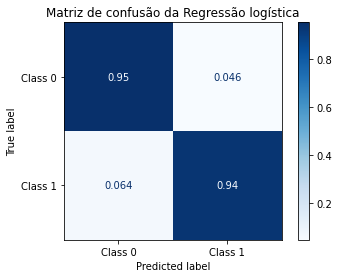

In [29]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Matriz de confusão da Regressão logística');

#### Duas listas com as top 10 palavras mais significantes para o sentimento positivo e negativo são criadas e mostradas nos gráficos a seguir.

In [30]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


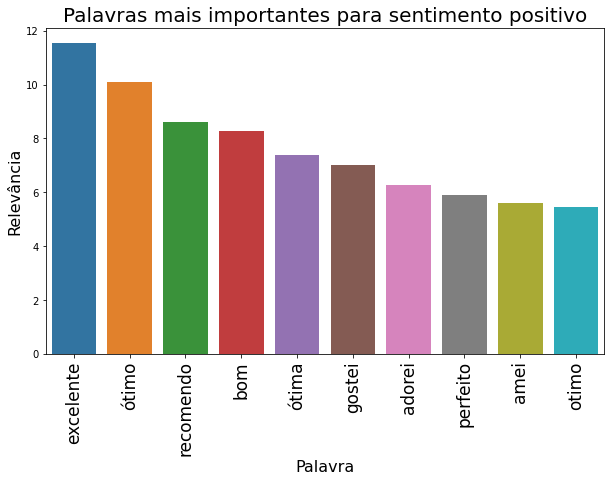

In [31]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Palavras mais importantes para sentimento positivo",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.xticks(fontsize=17, rotation=90
          )
plt.ylabel('Relevância', fontsize = 16)
plt.xlabel('Palavra', fontsize = 16);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


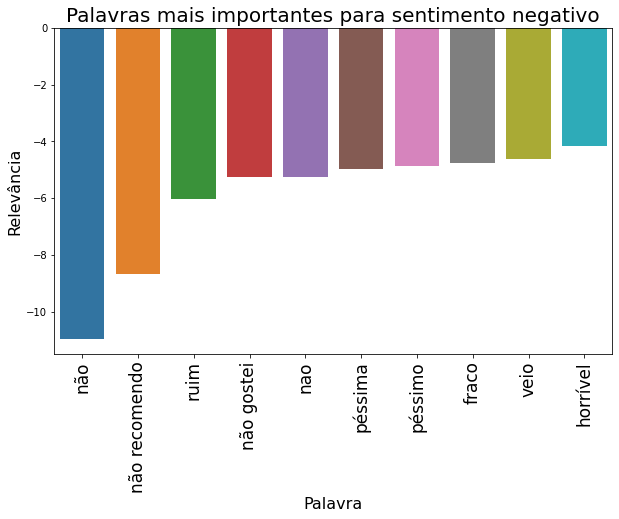

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Palavras mais importantes para sentimento negativo",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.xticks(fontsize=17, rotation=90)
plt.ylabel('Relevância', fontsize = 16)
plt.xlabel('Palavra', fontsize = 16);

#### Realizando alguns testes com o modelo:
#### A função *predict_proba* mostra um array com a probabilidade de uma sentença ser positiva ou negativa, sendo a primeira posição do array a probabilidade negativa , e a segunda posição a probabilidade positiva.

#### Se Prob Neg >= 0.65 - Negativo
#### Se Prob Neg =< 0.35 - Positivo
#### Se prob Neg >0.35 e <0.65 - Neutro

In [33]:
test_review = cv.transform(["""Banco mais bem administrado do Brasil
                               e Mundo."""])
lr.predict_proba(test_review)

array([[0.16921871, 0.83078129]])

In [34]:
  test_review = cv.transform(["v"])
lr.predict_proba(test_review)

array([[0.46776699, 0.53223301]])

#### Salvando o arquivo PKL do modelo 

In [35]:
model_list = [pre_processor,cv,lr,train_feature_set,test_feature_set,y_train,y_test]
pickle.dump(model_list, open(r'/gdrive/My Drive/Análise de Sentimentos/Sentiment_analysys.pkl', 'wb'))

In [36]:
modelo_carregado = pickle.load(open(r'/gdrive/My Drive/Análise de Sentimentos/Sentiment_analysys.pkl', 'rb'))

#### Classificando as sentenças em Sentimento Positivo, Negativo ou Neutro.

In [62]:
def Sentiment_classified(prob):
  if prob >= 0.65:
    return 'Negativo'
  elif prob <= 0.35:
    return 'Positivo'
  else:
    return 'Neutro'

In [64]:
Sentiment_classified(modelo_carregado[2].predict_proba(modelo_carregado[1].transform \
                    ([modelo_carregado[0]("""O produto atendeu as expectativas e a entrega foi rápida""")]))[0][0])

'Positivo'

In [65]:
Sentiment_classified(modelo_carregado[2].predict_proba(modelo_carregado[1].transform \
                    ([modelo_carregado[0]("""Meu pedido foi cancelado e nao obtive o retorno financeiro nao comprem """)]))[0][0])

'Negativo'

In [83]:
Sentiment_classified(modelo_carregado[2].predict_proba(modelo_carregado[1].transform \
                    ([modelo_carregado[0]("""Ainda pode reduzir o preço do frete""")]))[0][0])

'Neutro'